In [126]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import os
import tqdm

# load coordinate data

In [137]:
path_cor_train = '../../data/ds9_dataset/labels_txt/train/'
path_cor_test = '../../data/ds9_dataset/labels_txt/test/'

In [138]:
# load corrdinates of the image from the text file
files_name_cor_train = glob.glob(os.path.join(path_cor_train, "*.txt"))
files_name_cor_test = glob.glob(os.path.join(path_cor_test, "*.txt"))

In [139]:
# print len with good display
print('Number of training images: {}'.format(len(files_name_cor_train)))
print('Number of testing images: {}'.format(len(files_name_cor_test)))

Number of training images: 20
Number of testing images: 6


In [102]:
# read data in txt file
with open(files_name_cor_train[0], 'r') as f:
    data = f.read()
    print(data)

Cluster 2984.1311 1280.0615 100 100
Cluster 2836.9031 1142.0614 100 100
Unknown 2653.5243 1506.0657 100 100
Cluster 2565.6845 1030.0693 100 100
Unknown 2547.6279 1506.0703 100 100
Cluster 2271.3073 1982.09 100 100
Cluster 2268.6526 1188.0902 100 100
Cluster 1690.1643 1732.167 100 100
Cluster 1207.5897 3378.268 100 100
Cluster 861.35442 2602.3607 100 100



# load image data

In [103]:
path_img_train = '../../data/ds9_dataset/full_img_flip/train/*'
path_img_test = '../../data/ds9_dataset/full_img_flip/test/*'

In [104]:
# get all folder name
folder_name_train = glob.glob(path_img_train)
folder_name_test = glob.glob(path_img_test)

In [105]:
folder_name_train

['../../data/ds9_dataset/full_img_flip/train\\ASINH',
 '../../data/ds9_dataset/full_img_flip/train\\Linear',
 '../../data/ds9_dataset/full_img_flip/train\\Log',
 '../../data/ds9_dataset/full_img_flip/train\\Power',
 '../../data/ds9_dataset/full_img_flip/train\\SINH',
 '../../data/ds9_dataset/full_img_flip/train\\Sqrt',
 '../../data/ds9_dataset/full_img_flip/train\\Squarded']

## display box on image

In [106]:
def plot_bounding_box(items_list, img):
    # read data in items_list then save in a list
    with open(items_list, "r") as f:
        items_list = f.readlines()
        items_list = [item.strip().split(" ") for item in items_list]
    print(items_list)
    plt.rcParams['figure.figsize'] = [15, 15]
    for item in items_list:
        x = float(item[1])
        y = float(item[2])
        w = float(item[3])
        h = float(item[4])
        x_min = x - w
        x_max = x + w
        y_min = y - h
        y_max = y + h
        plt.plot([x_min, x_max], [y_min, y_min], c='r')
        plt.plot([x_min, x_max], [y_max, y_max], c='r')
        plt.plot([x_min, x_min], [y_min, y_max], c='r')
        plt.plot([x_max, x_max], [y_min, y_max], c='r')
    plt.imshow(img, cmap='gray')
    plt.show()

In [107]:
x = folder_name_train[0] + '/*.jpg'
# read first image in x
x = glob.glob(x)[0]
x

'../../data/ds9_dataset/full_img_flip/train\\ASINH\\hst_10190_12_acs_wfc_f814w_j90o12_drc.jpg'

In [108]:
files_name_cor_train[0]

'../../data/ds9_dataset/labels_txt\\hst_10190_12_acs_wfc_f814w_j90o12_drc.txt'

[['Cluster', '2984.1311', '1280.0615', '100', '100'], ['Cluster', '2836.9031', '1142.0614', '100', '100'], ['Unknown', '2653.5243', '1506.0657', '100', '100'], ['Cluster', '2565.6845', '1030.0693', '100', '100'], ['Unknown', '2547.6279', '1506.0703', '100', '100'], ['Cluster', '2271.3073', '1982.09', '100', '100'], ['Cluster', '2268.6526', '1188.0902', '100', '100'], ['Cluster', '1690.1643', '1732.167', '100', '100'], ['Cluster', '1207.5897', '3378.268', '100', '100'], ['Cluster', '861.35442', '2602.3607', '100', '100']]


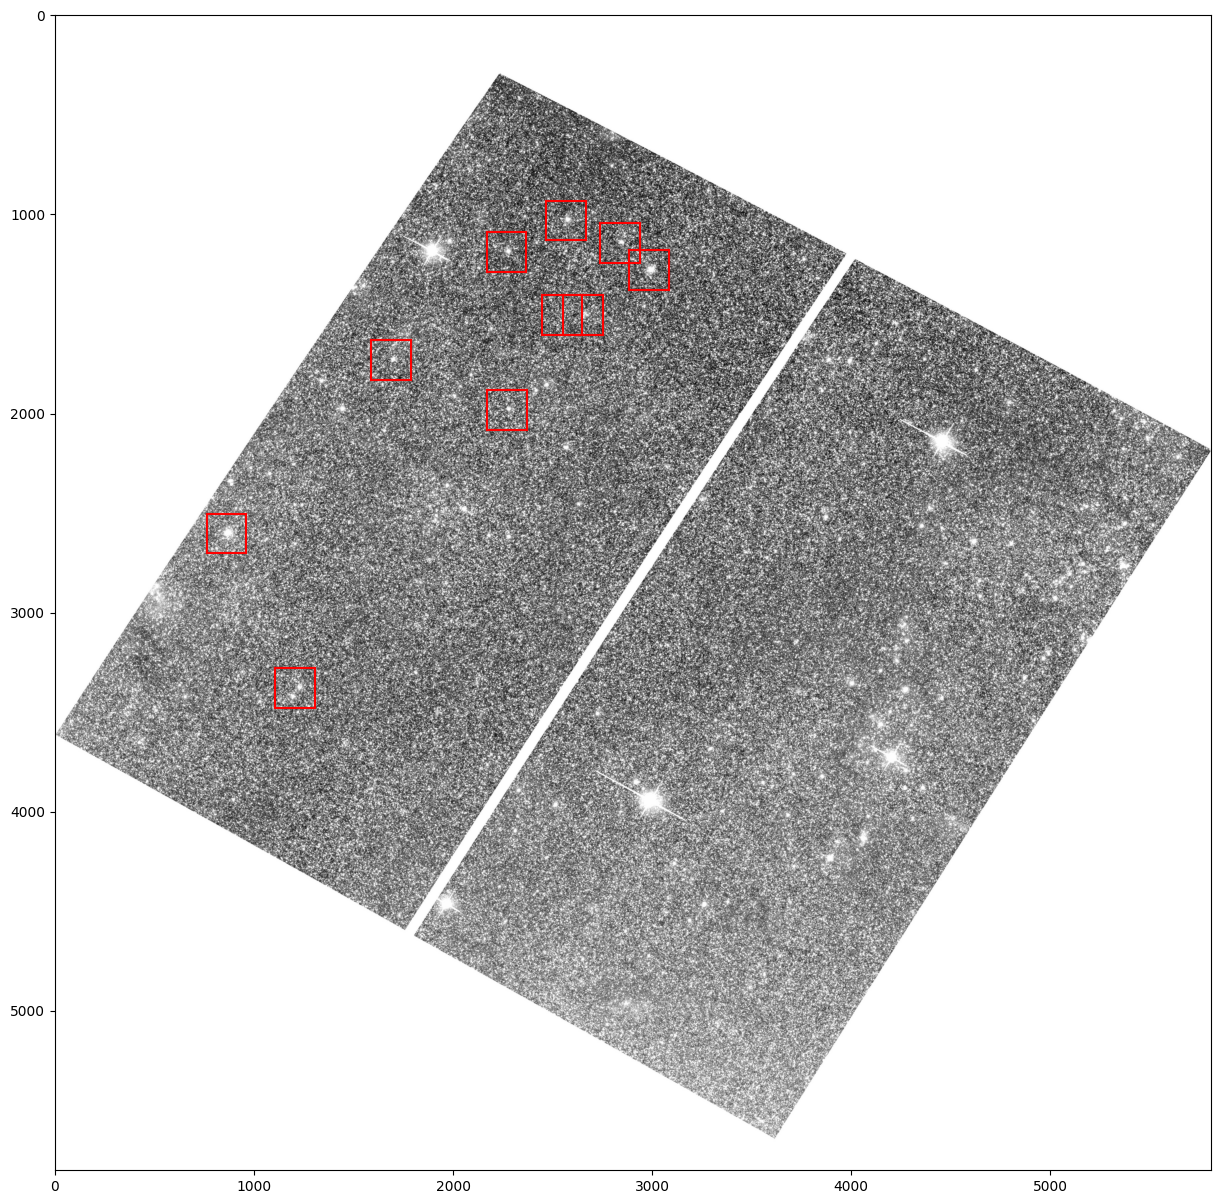

In [109]:
# plot bounding box
img = cv2.imread(x)
plot_bounding_box(files_name_cor_train[0], img)

## cropping process

In [195]:
def coordinate_index(items_list):
    with open(items_list, "r") as f:
        items_list = f.readlines()
        items_list = [item.strip().split(" ") for item in items_list]
    # print(items_list)
    # calculate x_min, x_max, y_min, y_max then return
    coor_list = []
    for item in items_list:
        label = item[0]
        x = float(item[1])
        y = float(item[2])
        w = float(item[3])
        h = float(item[4])
        x_min = x - w
        x_max = x + w
        y_min = y - h
        y_max = y + h
        coor_list.append([x_min, x_max, y_min, y_max, x, y, label, h, w])
    return coor_list

In [196]:
# create function to return small image after crop with size that intialized
def crop_image(img, new_h, new_w, coor_list): # use function per image
    # load coordinate of the image
    coor_list = coordinate_index(coor_list)
    new_coor = []

    img_h = img.shape[0]
    img_w = img.shape[1]
    cropped_list = []
    for j in range(0, img_h, new_h): # for y axis
        # calculate the end of the crop whole 4 corner
        start_y = j
        end_y = j + new_h
        if end_y > img_h: # if the end of the crop is out of the image
            end_y = img_h
            start_y = img_h - new_h
        for i in range(0, img_w, new_w): # for x axis
            start_x = i
            end_x = i + new_w
            if end_x > img_w: # if the end of the crop is out of the image
                end_x = img_w
                start_x = img_w - new_w

            # calculate the coordinate of the object in the crop
            temp_coor = [] # keep per small image
            for coor in coor_list: # check if coordinate of the crop is in the coordinate of the object
                if coor[0] >= start_x and coor[1] <= end_x and coor[2] >= start_y and coor[3] <= end_y:
                    # change coordinate of the object to the new coordinate follow new crop
                    new_x_min = coor[0] - start_x
                    new_x_max = coor[1] - start_x
                    new_y_min = coor[2] - start_y
                    new_y_max = coor[3] - start_y
                    new_x = coor[4] - start_x
                    new_y = coor[5] - start_y
                    label = coor[6]
                    h = coor[7]
                    w = coor[8]
                    # temp_coor.append([label, new_x_min, new_x_max, new_y_min, new_y_max, new_x, new_y])
                    
                    if label != 'Cluster':
                        pass
                    else:
                        temp_coor.append([label, new_x, new_y, h, w, new_x_min, new_x_max, new_y_min, new_y_max])

            new_coor.append(temp_coor)
            cropped_list.append(img[start_y:end_y, start_x:end_x])
    return cropped_list, new_coor

In [115]:
img = cv2.imread(x, 0) # 0 for grayscale
img.shape # -> [height, width]

(5802, 5810)

In [121]:
new_h = 1024
new_w = 1024
# new_h = 2048
# new_w = 2048
# new_h = 4096
# new_w = 4096
cropped_list, new_coordinate = crop_image(img, new_h, new_w, files_name_cor_train[0])

In [117]:
print(len(cropped_list), len(new_coordinate))
print(new_coordinate)
for i in new_coordinate:
    print(len(i), end=' ')

36 36
[[], [], [], [], [], [], [], [['Cluster', 666.1642999999999, 708.1669999999999, 100.0, 100.0, 566.1642999999999, 766.1642999999999, 608.1669999999999, 808.1669999999999]], [['Cluster', 788.9031, 118.06140000000005, 100.0, 100.0, 688.9031, 888.9031, 18.06140000000005, 218.06140000000005], ['Cluster', 220.6525999999999, 164.0902000000001, 100.0, 100.0, 120.6525999999999, 320.6525999999999, 64.0902000000001, 264.0902000000001]], [], [], [], [['Cluster', 861.35442, 554.3607000000002, 100.0, 100.0, 761.35442, 961.35442, 454.3607000000002, 654.3607000000002]], [], [], [], [], [], [], [['Cluster', 183.5897, 306.26800000000003, 100.0, 100.0, 83.5897, 283.5897, 206.26800000000003, 406.26800000000003]], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
0 0 0 0 0 0 0 1 2 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [118]:
print(len(cropped_list), cropped_list[0].shape)

36 (1024, 1024)


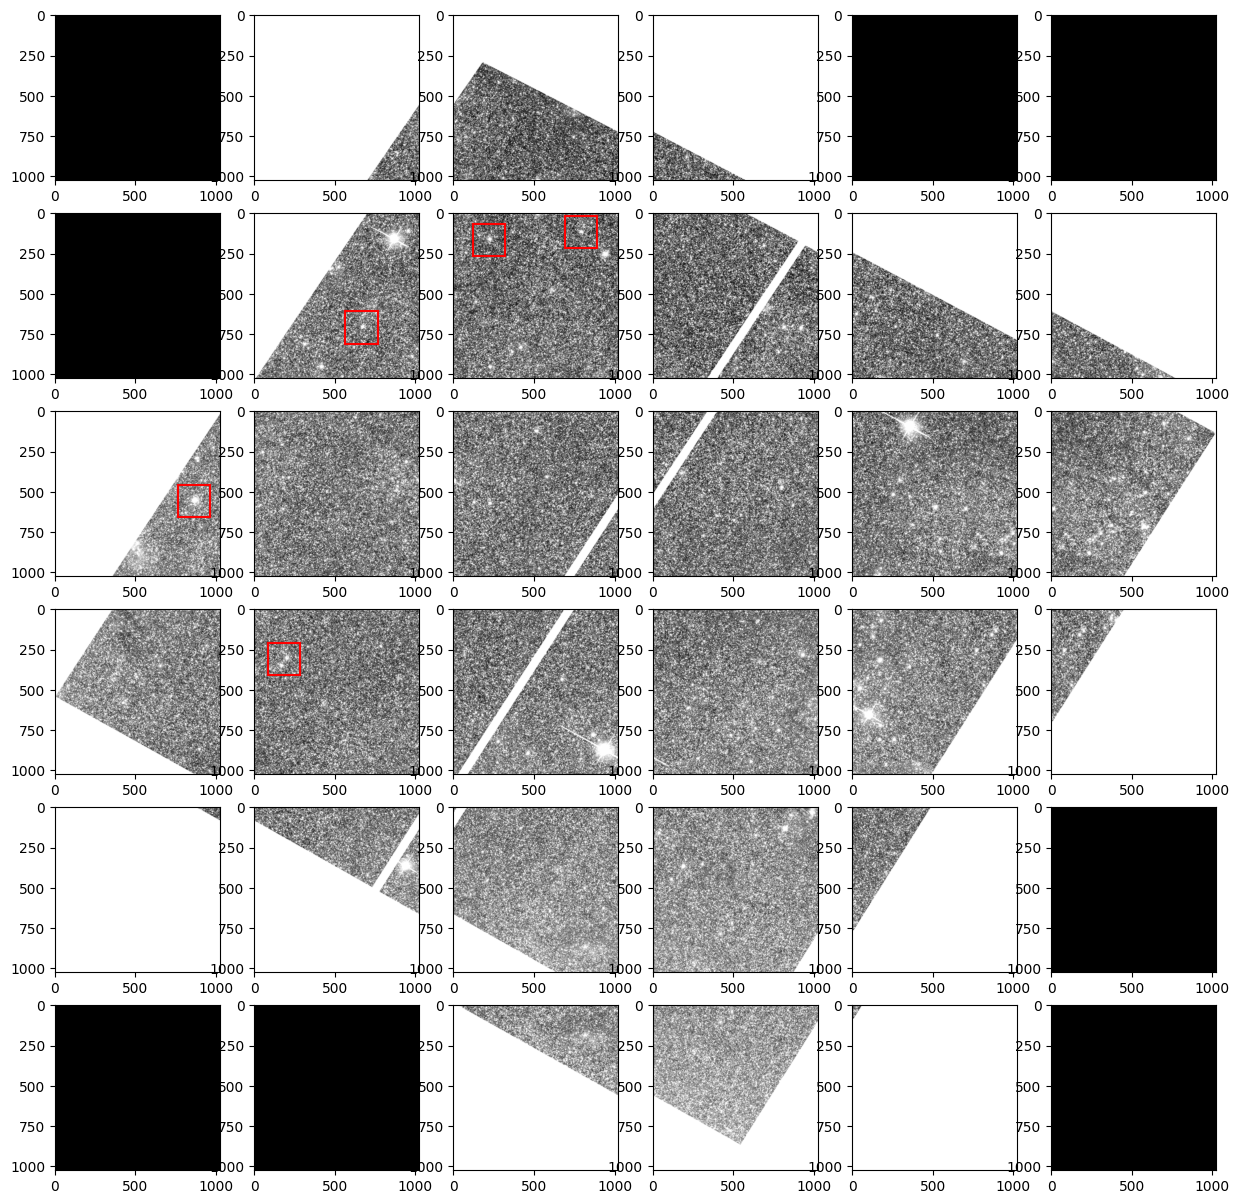

In [122]:
# plot all cropped image in cropped_list by row and column come from square root of length of cropped_list then plot scatter of coordinate of the object
plt.rcParams['figure.figsize'] = [15, 15]
# plot all cropped image in list by row and column come from square root of length of list
row = int(np.sqrt(len(cropped_list)))
column = int(np.sqrt(len(cropped_list)))
for i in range(len(cropped_list)):
    plt.subplot(row, column, i+1)
    plt.imshow(cropped_list[i], cmap="gray")
    for j in new_coordinate[i]:
        x = j[1]
        y = j[2]
        w = j[3]
        h = j[4]
        x_min = j[5]
        x_max = j[6]
        y_min = j[7]
        y_max = j[8]
        plt.plot([x_min, x_max], [y_min, y_min], c='r')
        plt.plot([x_min, x_max], [y_max, y_max], c='r')
        plt.plot([x_min, x_min], [y_min, y_max], c='r')
        plt.plot([x_max, x_max], [y_min, y_max], c='r')
plt.show()

# do it with loop

In [123]:
# the image is saved in the same old resolution = len data in numpy array and display the image by flip vertical with inverte y-axis
def save_image(data, cm, fn):
    sizes = np.shape(data)
    height = float(sizes[0])
    width = float(sizes[1])
     
    fig = plt.figure()
    fig.set_size_inches(width/height, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
 
    ax.imshow(data, cmap=cm)
    plt.savefig(fn, dpi = height) 
    plt.close()

In [ ]:
# read jpg file
path = '../../data/jpg/global_F814W_InvertY/'
files_name = glob.glob(os.path.join(path, "*.jpg"))

In [ ]:
# load coordinates of the image from the text file
path_cor = '../../data/jpg/labels_global_F814W_InvertY/'
files_name_cor = glob.glob(os.path.join(path_cor, "*.txt"))

In [ ]:
files_name[0]

'../../data/jpg/global_F814W_InvertY\\hst_10190_12_acs_wfc_f814w_j90o12_drc.jpg'

In [ ]:
files_name_cor[0]

'../../data/jpg/labels_global_F814W_InvertY\\hst_10190_12_acs_wfc_f814w_j90o12_drc.txt'

In [ ]:
new_h = 1024
new_w = 1024

## with filters

In [ ]:
from functions import load_obj

In [ ]:
folder_path = load_obj('../../data/jpg/24_images/24_7filters_processing/', '*')
fillter_list = ['Linear', 'Log', 'Power', 'Sqrt', 'Squarded', 'ASINH', 'SINH']
# fillter_list = ['Power', 'Log']

In [ ]:
folder_path = folder_path[:-1] # skip testing folder
folder_path

['../../data/jpg/24_images/24_7filters_processing\\ASINH',
 '../../data/jpg/24_images/24_7filters_processing\\Linear',
 '../../data/jpg/24_images/24_7filters_processing\\Log',
 '../../data/jpg/24_images/24_7filters_processing\\Power',
 '../../data/jpg/24_images/24_7filters_processing\\SINH',
 '../../data/jpg/24_images/24_7filters_processing\\Sqrt',
 '../../data/jpg/24_images/24_7filters_processing\\Squarded']

In [ ]:
# load coordinates of the image from the text file
path_cor = load_obj('../../data/jpg/24_images/labels_24_7filters_processing/', 'txt')
path_cor

['../../data/jpg/24_images/labels_24_7filters_processing\\hst_10190_12_acs_wfc_f814w_j90o12_drc.txt',
 '../../data/jpg/24_images/labels_24_7filters_processing\\hst_10190_13_acs_wfc_f814w_j90o13_drc.txt',
 '../../data/jpg/24_images/labels_24_7filters_processing\\hst_10190_28_acs_wfc_f814w_j90o28_drc.txt',
 '../../data/jpg/24_images/labels_24_7filters_processing\\hst_14610_01_acs_wfc_f814w_jdb601_drc.txt',
 '../../data/jpg/24_images/labels_24_7filters_processing\\hst_14610_02_acs_wfc_f814w_jdb602_drc.txt',
 '../../data/jpg/24_images/labels_24_7filters_processing\\hst_14610_08_acs_wfc_f814w_jdb608_drc.txt',
 '../../data/jpg/24_images/labels_24_7filters_processing\\hst_14610_12_acs_wfc_f814w_jdb612_drc.txt',
 '../../data/jpg/24_images/labels_24_7filters_processing\\hst_14610_18_acs_wfc_f814w_jdb618_drc.txt',
 '../../data/jpg/24_images/labels_24_7filters_processing\\hst_14610_23_acs_wfc_f814w_jdb623_drc.txt',
 '../../data/jpg/24_images/labels_24_7filters_processing\\hst_14610_26_acs_wfc_f81

In [ ]:
new_h = 1024
new_w = 1024

In [ ]:
# testing data
folder_path = load_obj('../../data/jpg/24_images/24_7filters_processing/testing_set/', '*')
path_cor = load_obj('../../data/jpg/24_images/labels_24_7filters_processing/testing_data/', 'txt')

## cropping all space in the image

In [ ]:
# extract new images from list_path
# extract images and coordinates from list_path

# big cropping, crop all space in the image

for i in range(len(folder_path)):
    # files_name = glob.glob(os.path.join(list_path[i], "*.jpg"))
    files_name = load_obj(folder_path[i], 'jpg')
    print('processing fillter : ', fillter_list[i])
    for j in range(len(files_name)):
        c_img_name = files_name[j].split("\\")[-1].split(".")[0]
        c_cor_name = path_cor[j].split("\\")[-1].split(".")[0]

        if c_img_name == c_cor_name:
            # print process of the image
            # print('processing file : ', c_img_name)

            img = cv2.imread(files_name[j], 0)
            cropped_list, new_coordinate = crop_image(img, new_h, new_w, path_cor[j])
        
            for k in range(len(cropped_list)):
                # save cropped image in to new folder with file name is the same as the original image

                # save_image(cropped_list[k], 'gray', '../../data/data_augmentation/24_images/full_img_cropped/' + fillter_list[i] + '/' + c_img_name + '_' + str(k+1) + '.jpg')
                
                save_image(cropped_list[k], 'gray', '../../data/data_augmentation/24_images/full_img_cropped/testing_data/' + fillter_list[i] + '/' + c_img_name + '_' + str(k+1) + '.jpg')
               
                # save coordinate of the object in the cropped image to new folder with file name is the same as the original image
                with open('../../data/data_augmentation/24_images/coordinate/testing_data/' + fillter_list[i] + '/' + c_img_name + '_' + str(k+1) + '.txt', 'w') as f:
                    for coor in new_coordinate[k]:
                        # represent [label, x, y, h, w, x_min, x_max, y_min, y_max]
                        f.write(str(coor[0]) + ' ' + str(coor[1]) + ' ' + str(coor[2]) + ' ' + str(coor[3]) + ' ' + str(coor[4]) + ' ' + str(coor[5]) + ' ' + str(coor[6]) + ' ' + str(coor[7]) + ' ' + str(coor[8]) + '\n')
        
    print()

processing fillter :  Linear

processing fillter :  Log

processing fillter :  Power

processing fillter :  Sqrt

processing fillter :  Squarded

processing fillter :  ASINH

processing fillter :  SINH



## extract images and coordinates only containing objects in the image

In [ ]:
# testing data
# folder_path = load_obj('../../data/jpg/24_images/24_7filters_processing/testing_set/', '*')
# path_cor = load_obj('../../data/jpg/24_images/labels_24_7filters_processing/testing_data/', 'txt')

In [ ]:
'''
Note : coordinate files were used with all filters
'''

In [ ]:
# extract new images from list_path
# extract images and coordinates

for i in range(len(fillter_list)):
    # files_name = glob.glob(os.path.join(list_path[i], "*.jpg"))
    temp_fil_name = fillter_list[i]
    for w in folder_path:
        if temp_fil_name in w:
            temp_path = w
            break
    files_name = load_obj(temp_path, 'jpg')
    # print(files_name)
    # files_name = load_obj(folder_path[i], 'jpg')
    
    print('processing fillter : ', temp_fil_name)
    for j in range(len(files_name)):
        c_img_name = files_name[j].split("\\")[-1].split(".")[0]
        c_cor_name = path_cor[j].split("\\")[-1].split(".")[0]
        # print(files_name[j], path_cor[j])
        # break

        if c_img_name == c_cor_name:
            # print process of the image
            # print('processing file : ', c_img_name)

            img = cv2.imread(files_name[j], 0)
            cropped_list, new_coordinate = crop_image(img, new_h, new_w, path_cor[j])
            
            for k in range(len(cropped_list)):
                if new_coordinate[k] == []: # no object in the cropped image
                    pass
                else:
                    # save cropped image in to new folder with file name is the same as the original image

                    # save_image(cropped_list[k], 'gray', '../../data/data_augmentation/24_images/only_obj_cropped/' + fillter_list[i] + '/' + c_img_name + '_' + str(k+1) + '.jpg')
                    
                    save_image(cropped_list[k], 'gray', '../../data/data_augmentation/24_images/only_obj_cropped/testing_data/' + fillter_list[i] + '/' + c_img_name + '_' + str(k+1) + '.jpg')
                    # save coordinate of the object in the cropped image to new folder with file name is the same as the original image
                    
                    
                    # with open('../../data/data_augmentation/24_images/coordinate_contain_obj/' + fillter_list[i] + '/' + c_img_name + '_' + str(k+1) + '.txt', 'w') as f:
                    with open('../../data/data_augmentation/24_images/coordinate_contain_obj/testing_data/' + fillter_list[i] + '/' + c_img_name + '_' + str(k+1) + '.txt', 'w') as f:
                        for coor in new_coordinate[k]:
                            # represent [label, x, y, h, w, x_min, x_max, y_min, y_max]
                            f.write(str(coor[0]) + ' ' + str(coor[1]) + ' ' + str(coor[2]) + ' ' + str(coor[3]) + ' ' + str(coor[4]) + ' ' + str(coor[5]) + ' ' + str(coor[6]) + ' ' + str(coor[7]) + ' ' + str(coor[8]) + '\n')
        else:
            print('error, file name is not match')
    print()

processing fillter :  Linear

processing fillter :  Log

processing fillter :  Power

processing fillter :  Sqrt

processing fillter :  Squarded

processing fillter :  ASINH

processing fillter :  SINH



# Export with ds9 filters

In [ ]:
"""
Note : After processing, you need to convert the coordinate to yolo format
"""

In [193]:
# create save_img function to save image with 75% resolution
def save_image(img, path):
    # save image with 75% quality
    cv2.imwrite(path, img, [cv2.IMWRITE_JPEG_QUALITY, 75])

In [140]:
print(path_cor_train)
print(path_img_train)
print(path_cor_test)
print(path_img_test)

../../data/ds9_dataset/labels_txt/train/
../../data/ds9_dataset/full_img_flip/train/*
../../data/ds9_dataset/labels_txt/test/
../../data/ds9_dataset/full_img_flip/test/*


In [141]:
# get all subfolder in the folder
sub_train = glob.glob(os.path.join(path_img_train))
sub_test = glob.glob(os.path.join(path_img_test))
sub_coor_train = glob.glob(os.path.join(path_cor_train))
sub_coor_test = glob.glob(os.path.join(path_cor_test))
# print details

print('subfolder in training data : ', (sub_train))
print('subfolder in testing data : ', (sub_test))
print('subfolder in training coordinate : ', (sub_coor_train))
print('subfolder in testing coordinate : ', (sub_coor_test))

subfolder in training data :  ['../../data/ds9_dataset/full_img_flip/train\\ASINH', '../../data/ds9_dataset/full_img_flip/train\\Linear', '../../data/ds9_dataset/full_img_flip/train\\Log', '../../data/ds9_dataset/full_img_flip/train\\Power', '../../data/ds9_dataset/full_img_flip/train\\SINH', '../../data/ds9_dataset/full_img_flip/train\\Sqrt', '../../data/ds9_dataset/full_img_flip/train\\Squarded']
subfolder in testing data :  ['../../data/ds9_dataset/full_img_flip/test\\ASINH', '../../data/ds9_dataset/full_img_flip/test\\Linear', '../../data/ds9_dataset/full_img_flip/test\\Log', '../../data/ds9_dataset/full_img_flip/test\\Power', '../../data/ds9_dataset/full_img_flip/test\\SINH', '../../data/ds9_dataset/full_img_flip/test\\Sqrt', '../../data/ds9_dataset/full_img_flip/test\\Squarded']
subfolder in training coordinate :  ['../../data/ds9_dataset/labels_txt/train/']
subfolder in testing coordinate :  ['../../data/ds9_dataset/labels_txt/test/']


## for training set

In [201]:
save_path_train_img = '../../data/ds9_dataset/sub_img/train/'
save_path_train_label = '../../data/ds9_dataset/labels_sub_txt/train/'

In [203]:
# read all items in sub_coor_train
sub_iterate_coordinate = glob.glob(os.path.join(sub_coor_train[0], "*.txt"))
print(' length of sub_iterate_coordinate : ', len(sub_iterate_coordinate))

for i in tqdm.tqdm(range(len(sub_train))):
    # all items in the subfolder
    sub_iterate_filter = glob.glob(os.path.join(sub_train[i], "*.jpg"))
    
    print('processing filter : ', sub_train[i].split("\\")[-1])
    for j in tqdm.tqdm(range(len(sub_iterate_filter))):
        c_img_name = sub_iterate_filter[j].split("\\")[-1].split(".")[0]
        c_cor_name = sub_iterate_coordinate[j].split("\\")[-1].split(".")[0]

        if c_img_name == c_cor_name:
            # print process of the image
            # print('processing file : ', c_img_name)

            img = cv2.imread(sub_iterate_filter[j], 0)
            cropped_list, new_coordinate = crop_image(img, new_h, new_w, sub_iterate_coordinate[j])
            for k in range(len(cropped_list)):
                if new_coordinate[k] == []:
                    pass
                else:
                    # save cropped image in to new folder with file name is the same as the original image
                    save_image(cropped_list[k], save_path_train_img + sub_train[i].split("\\")[-1] + '/' + c_img_name + '_' + str(k+1) + '.jpg')
                    # save coordinate of the object in the cropped image to new folder with file name is the same as the original image
                    with open(save_path_train_label + sub_train[i].split("\\")[-1] + '/' + c_img_name + '_' + str(k+1) + '.txt', 'w') as f:
                        for coor in new_coordinate[k]:
                            # represent [label, x, y, h, w, x_min, x_max, y_min, y_max]
                            f.write(str(coor[0]) + ' ' + str(coor[1]) + ' ' + str(coor[2]) + ' ' + str(coor[3]) + ' ' + str(coor[4]) + ' ' + str(coor[5]) + ' ' + str(coor[6]) + ' ' + str(coor[7]) + ' ' + str(coor[8]) + '\n')
        else:
            print('error, file name is not match')

 length of sub_iterate_coordinate :  20


  0%|          | 0/7 [00:00<?, ?it/s]

processing filter :  ASINH


 14%|█▍        | 1/7 [00:05<00:33,  5.64s/it]

processing filter :  Linear


 29%|██▊       | 2/7 [00:11<00:28,  5.63s/it]

processing filter :  Log


 43%|████▎     | 3/7 [00:16<00:20,  5.24s/it]

processing filter :  Power


 57%|█████▋    | 4/7 [00:20<00:15,  5.10s/it]

processing filter :  SINH


 71%|███████▏  | 5/7 [00:26<00:10,  5.17s/it]

processing filter :  Sqrt


 86%|████████▌ | 6/7 [00:31<00:05,  5.19s/it]

processing filter :  Squarded


100%|██████████| 7/7 [00:36<00:00,  5.27s/it]


## for testing set

In [204]:
save_path_test_img = '../../data/ds9_dataset/sub_img/test/'
save_path_test_label = '../../data/ds9_dataset/labels_sub_txt/test/'

In [205]:
# read all items in sub_coor_train
sub_iterate_coordinate = glob.glob(os.path.join(sub_coor_test[0], "*.txt"))
print(' length of sub_iterate_coordinate : ', len(sub_iterate_coordinate))

for i in tqdm.tqdm(range(len(sub_test))):
    # all items in the subfolder
    sub_iterate_filter = glob.glob(os.path.join(sub_test[i], "*.jpg"))
    
    print('processing filter : ', sub_test[i].split("\\")[-1])
    for j in tqdm.tqdm(range(len(sub_iterate_filter))):
        c_img_name = sub_iterate_filter[j].split("\\")[-1].split(".")[0]
        c_cor_name = sub_iterate_coordinate[j].split("\\")[-1].split(".")[0]

        if c_img_name == c_cor_name:
            # print process of the image
            # print('processing file : ', c_img_name)

            img = cv2.imread(sub_iterate_filter[j], 0)
            cropped_list, new_coordinate = crop_image(img, new_h, new_w, sub_iterate_coordinate[j])
            for k in range(len(cropped_list)):
                if new_coordinate[k] == []:
                    pass
                else:
                    # save cropped image in to new folder with file name is the same as the original image
                    save_image(cropped_list[k], save_path_test_img + sub_train[i].split("\\")[-1] + '/' + c_img_name + '_' + str(k+1) + '.jpg')
                    # save coordinate of the object in the cropped image to new folder with file name is the same as the original image
                    with open(save_path_test_label + sub_train[i].split("\\")[-1] + '/' + c_img_name + '_' + str(k+1) + '.txt', 'w') as f:
                        for coor in new_coordinate[k]:
                            # represent [label, x, y, h, w, x_min, x_max, y_min, y_max]
                            f.write(str(coor[0]) + ' ' + str(coor[1]) + ' ' + str(coor[2]) + ' ' + str(coor[3]) + ' ' + str(coor[4]) + ' ' + str(coor[5]) + ' ' + str(coor[6]) + ' ' + str(coor[7]) + ' ' + str(coor[8]) + '\n')
        else:
            print('error, file name is not match')

 length of sub_iterate_coordinate :  6


  0%|          | 0/7 [00:00<?, ?it/s]

processing filter :  ASINH


 14%|█▍        | 1/7 [00:01<00:10,  1.68s/it]

processing filter :  Linear


 29%|██▊       | 2/7 [00:03<00:08,  1.62s/it]

processing filter :  Log


 43%|████▎     | 3/7 [00:04<00:06,  1.54s/it]

processing filter :  Power


 57%|█████▋    | 4/7 [00:06<00:04,  1.53s/it]

processing filter :  SINH


 71%|███████▏  | 5/7 [00:07<00:03,  1.52s/it]

processing filter :  Sqrt


 86%|████████▌ | 6/7 [00:09<00:01,  1.53s/it]

processing filter :  Squarded


100%|██████████| 7/7 [00:10<00:00,  1.55s/it]
